In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit
import seaborn as sns
from pprint import pprint
import os
import sys 

In [2]:
# import transactions dataset
df = pd.read_csv('data/transactions.csv')
print(df.head())

# import auxiliary datasets (customer list, demographics, addresses)
df_customer_list = pd.read_csv('data/new_customer_list.csv')
df_demographics = pd.read_csv('data/customer_demographics.csv')
df_addresses = pd.read_csv('data/customer_addresses.csv')

   transaction_id  product_id  customer_id transaction_date online_order  \
0               1           2         2950       25/02/2017        False   
1               2           3         3120       21/05/2017         True   
2               3          37          402       16/10/2017        False   
3               4          88         3135       31/08/2017        False   
4               5          78          787       01/10/2017         True   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price standard_cost  product_first_sold_date  
0       71.49        $53.62                

# Part 0 - Data Preprocessing and Cleaning

In [3]:
# Convert 'transaction_date' to datetime
df.head()
df.head()
df.head()
df['transaction_date'] = pd.to_datetime(df['transaction_date'], dayfirst=True)

# Convert 'list_price' and 'standard_cost' to float
df['list_price'] = df['list_price'].replace('[\$,]', '', regex=True).astype(float)
df['standard_cost'] = df['standard_cost'].replace('[\$,]', '', regex=True).astype(float)

df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [4]:
# Check for missing values
print(df.isnull().sum())

transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64


In [5]:
# Drop null values of 'standard_cost'
df.dropna(subset=['standard_cost'], inplace=True)

In [6]:
# check for negative or zero values in 'standard_cost' and 'list_price'
print(df[df['standard_cost'].astype(float) <= 0].shape)
print(df[df['list_price'].astype(float) <= 0].shape)

(0, 13)
(0, 13)


In [7]:
# Drop rows with negative or zero values in 'standard_cost' and 'list_price'
df = df[df['standard_cost'].astype(float) > 0]
df = df[df['list_price'].astype(float) > 0]
print(f'New shape of the dataset: {df.shape}')

New shape of the dataset: (19803, 13)


# Part 1 - Descriptive Statistics
- Calculate mean, median, and mode of transaction amounts.
- Integrate Probability Density Function (PDF) to model the probability distribution.
- Compute the expected value of transaction amounts.

For transaction amounts, we have two parameters: 
- Standard Cost (SC) and
- List Price (LP).

List Price is the price at which a product or service is advertised or listed for sale. It's also sometimes referred to as the "sticker price" or the "retail price." The list price may not always reflect the actual price paid by customers, as discounts or promotions may apply.

Standard cost is the predetermined cost of manufacturing a product or providing a service, based on factors such as materials, labor, and overhead. It represents the expected cost under normal conditions and is used for planning, budgeting, and evaluating performance. Standard cost can serve as a benchmark against which actual costs are compared to assess efficiency and variance.

In [8]:
# Calculate mean, median, and mode of transaction amounts.

# list_price
mean = df['list_price'].mean()
median = df['list_price'].median()
mode = df.mode(axis=0)['list_price'][0]

print(f"Mean: {mean}, Median: {median}, Mode: {mode}")

# standard_cost

# remove $ sign and convert to float
df['standard_cost'] = df['standard_cost'].replace('[\$,]', '', regex=True).astype(float) 

mean_std_cost = df['standard_cost'].mean()
median_std_cost = df['standard_cost'].median()
mode_std_cost = df.mode(axis=0)['standard_cost'][0]

print(f"Mean: {mean_std_cost}, Median: {median_std_cost}, Mode: {mode_std_cost}")

Mean: 1107.9978659799021, Median: 1163.89, Mode: 2091.47
Mean: 556.0469512209311, Median: 507.58, Mode: 388.92


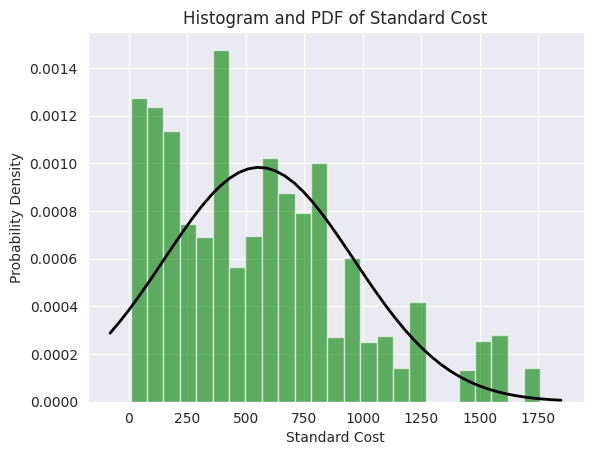

Estimated Mean: 556.0469512209311
Estimated Standard Deviation: 405.9454095958903


In [9]:
df.dropna(subset=['list_price', 'standard_cost'], inplace=True)
# Fit Gaussian distribution to 'standard_cost' column
mu, std = norm.fit(df['standard_cost'])

# Plot histogram of the data
plt.hist(df['standard_cost'], bins=25, density=True, alpha=0.6, color='g')

# Plot PDF of the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Standard Cost')
plt.ylabel('Probability Density')
plt.title('Histogram and PDF of Standard Cost')
plt.show()

print("Estimated Mean:", mu)
print("Estimated Standard Deviation:", std)

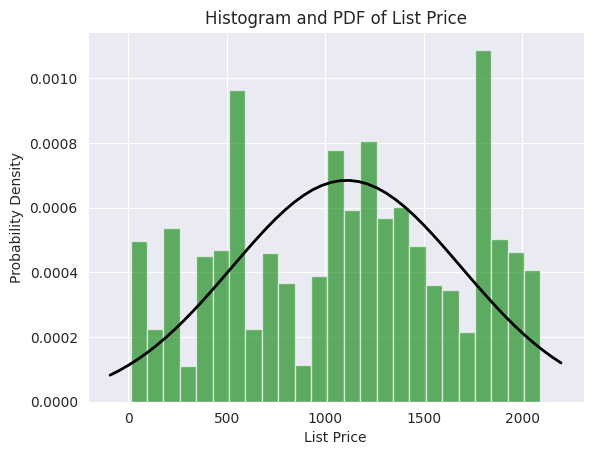

Estimated Mean: 1107.9978659799021
Estimated Standard Deviation: 582.7557459039022


In [10]:
# Fit Gaussian distribution to 'list_price' column
mu, std = norm.fit(df['list_price'])

# Plot histogram of the data
plt.hist(df['list_price'], bins=25, density=True, alpha=0.6, color='g')

# Plot PDF of the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 50)

p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('List Price')
plt.ylabel('Probability Density')
plt.title('Histogram and PDF of List Price')
plt.show()

print("Estimated Mean:", mu)
print("Estimated Standard Deviation:", std)